In [11]:
from pathlib import Path

import numpy
import torch
import yaml

from accent_estimator.generator import Generator
from accent_estimator.config import Config
from accent_estimator.dataset import create_dataset

from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
config_yaml_path = Path("./hiho_model_fmr40/config.yaml")
predictor_path = next(Path("./hiho_model_fmr40/").glob("predictor_*.pth"))
use_gpu = False

with config_yaml_path.open() as f:
    config_dict = yaml.safe_load(f)
config = Config.from_dict(config_dict)

generator = Generator(
    config=config, predictor=predictor_path, use_gpu=use_gpu
)

dataset = create_dataset(config.dataset)["valid"]

no7-announce_rohan4600_1530
pau gw o ch e N w a p i r a f u o k o k e n i s a r e pau p i i n a cl ts u n o m i ry o k u o k a t a r a r e t a pau 

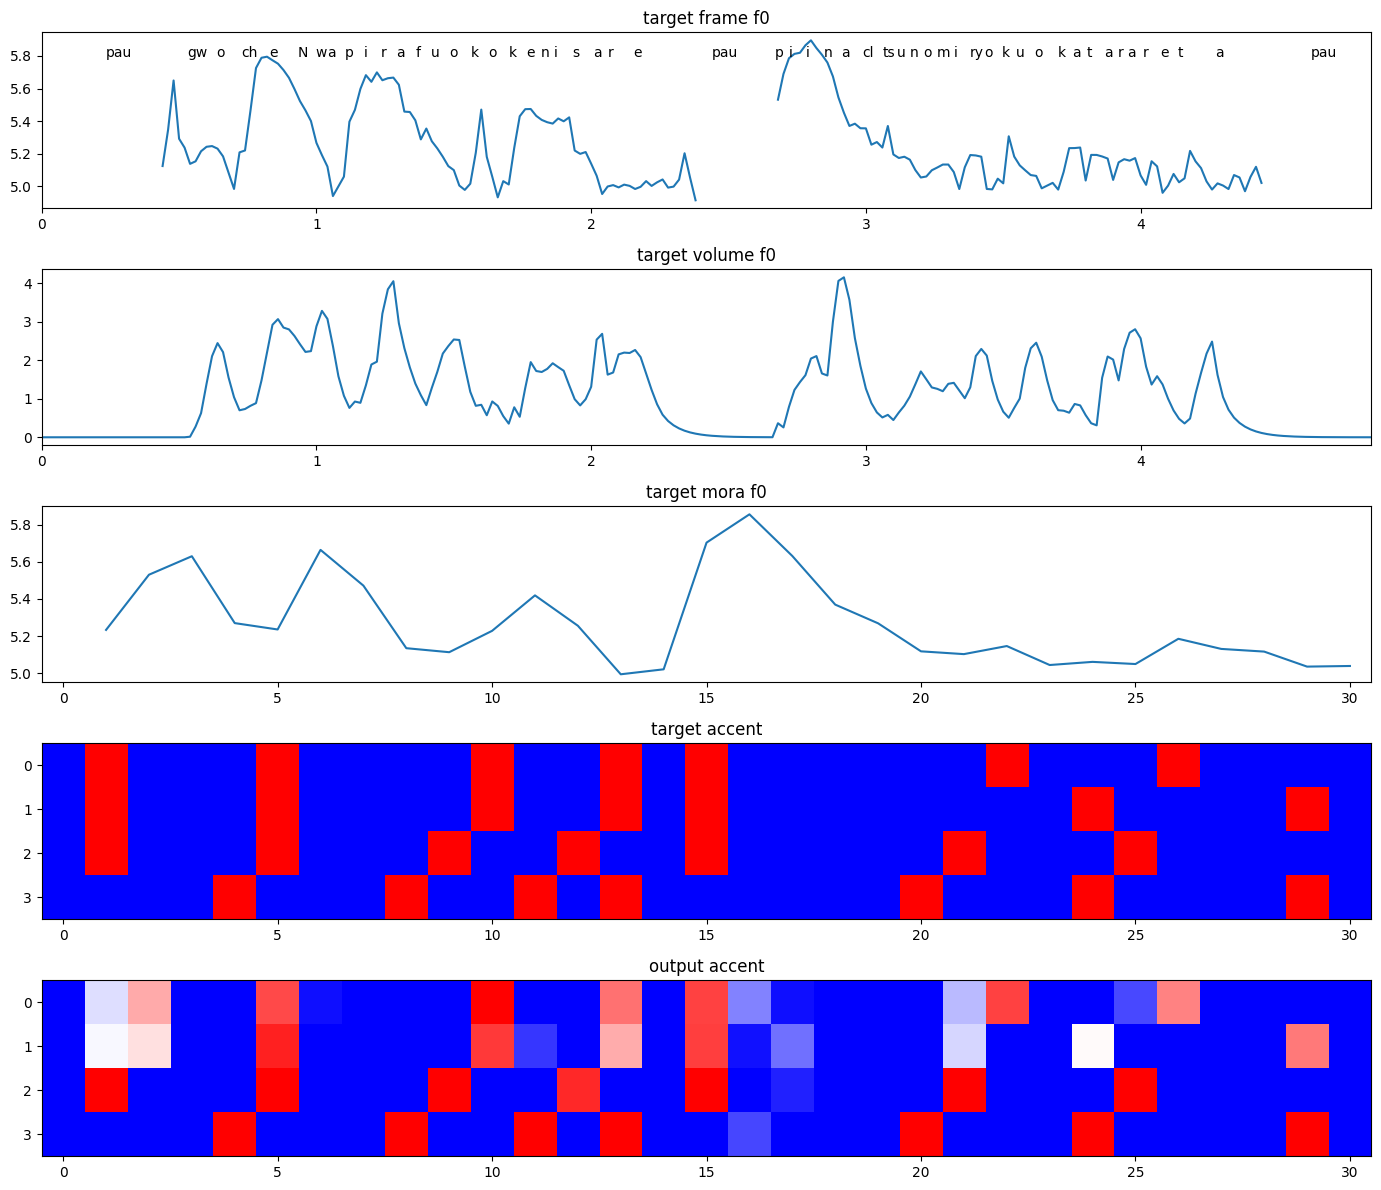

In [20]:
index = 15
data = dataset.datas[index].generate()
target_data = dataset[index]
print(dataset.datas[index].f0_path.stem)

target_phoneme_list = data.phoneme_list
target_volume = data.volume.resample(50)

target_frame_f0 = target_data["frame_f0"]
target_frame_phoneme = target_data["frame_phoneme"]
target_frame_mora_index = target_data["frame_mora_index"]
target_mora_f0 = target_data["mora_f0"]
target_mora_vowel = target_data["mora_vowel"]
target_mora_consonant = target_data["mora_consonant"]
target_accent_start = target_data["accent_start"]
target_accent_end = target_data["accent_end"]
target_accent_phrase_start = target_data["accent_phrase_start"]
target_accent_phrase_end = target_data["accent_phrase_end"]

output = generator(
    frame_f0_list=[target_frame_f0],
    frame_phoneme_list=[target_frame_phoneme],
    frame_mora_index_list=[target_frame_mora_index],
    mora_f0_list=[target_mora_f0],
    mora_vowel_list=[target_mora_vowel],
    mora_consonant_list=[target_mora_consonant],
)[0]

output_accent_start = output["accent_start"]
output_accent_end = output["accent_end"]
output_accent_phrase_start = output["accent_phrase_start"]
output_accent_phrase_end = output["accent_phrase_end"]

target_mora_f0[target_mora_f0 == 0] = numpy.nan

target_accent_matrix = numpy.empty((len(target_accent_start), 4))
target_accent_matrix[:, 0] = target_accent_start
target_accent_matrix[:, 1] = target_accent_end
target_accent_matrix[:, 2] = target_accent_phrase_start
target_accent_matrix[:, 3] = target_accent_phrase_end

output_accent_matrix = numpy.empty((len(output_accent_start), 4))
output_accent_matrix[:, 0] = output_accent_start
output_accent_matrix[:, 1] = output_accent_end
output_accent_matrix[:, 2] = output_accent_phrase_start
output_accent_matrix[:, 3] = output_accent_phrase_end

target_frame_f0[target_frame_f0 == 0] = numpy.nan

for p in target_phoneme_list:
    print(p.phoneme, end=" ")

plt.figure(figsize=(14, 12))
ny=5; nx=1; ni=1

plt.subplot(ny, nx, ni)
plt.plot(numpy.arange(len(target_frame_f0))/50, target_frame_f0)
for p in target_phoneme_list:
    x = (p.start + p.end) / 2
    plt.text(x, numpy.nanmax(target_frame_f0)-0.1, p.phoneme)
plt.xlim([0, (len(target_frame_f0)-1)/50])
plt.title("target frame f0")
ni+=1

plt.subplot(ny, nx, ni)
plt.plot(numpy.arange(len(target_volume))/50, target_volume)
plt.xlim([0, (len(target_volume)-1)/50])
plt.title("target volume f0")
ni+=1

plt.subplot(ny, nx, ni)
plt.plot(target_mora_f0)
plt.xlim(-0.5, len(target_mora_f0)-0.5)
plt.title("target mora f0")
ni+=1

plt.subplot(ny, nx, ni)
plt.set_cmap("bwr")
plt.imshow(target_accent_matrix.T, aspect="auto", origin="upper")
plt.title("target accent")
ni+=1

plt.subplot(ny, nx, ni)
plt.set_cmap("bwr")
plt.imshow(output_accent_matrix.T, aspect="auto", origin="upper")
plt.clim([-3, 3])
plt.title("output accent")
ni+=1

plt.tight_layout()

C:\Users\hihok\AppData\Local\Temp\ipykernel_9040\522928033.py:22: RuntimeWarning: invalid value encountered in double_scalars
  numpy.sum(a[a > 0] * b[a > 0]) / numpy.sum(b[a > 0])


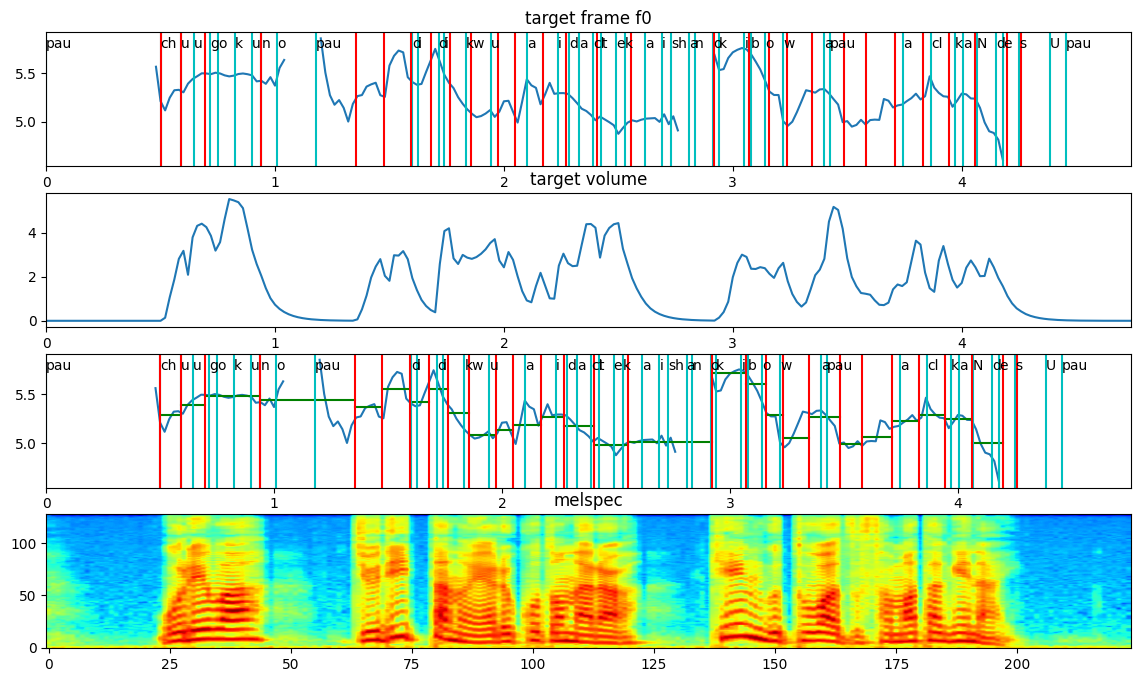

In [14]:
from typing import List, Optional
from acoustic_feature_extractor.data.phoneme import OjtPhoneme

import librosa

from accent_estimator.dataset import mora_phoneme_list

index = 0
frame_rate = 50

wave = librosa.load("no7-announce_rohan4600_0992.wav", sr=24000)[0]

def f0_mean(
    f0: numpy.ndarray,
    rate: float,
    split_second_list: List[float],
    weight: numpy.ndarray,
):
    indexes = numpy.floor(numpy.array(split_second_list) * rate).astype(int)
    output = numpy.array(
        [
            numpy.sum(a[a > 0] * b[a > 0]) / numpy.sum(b[a > 0])
            for a, b in zip(numpy.split(f0, indexes), numpy.split(weight, indexes))
        ],
        dtype=f0.dtype,
    )
    return output


def make_phoneme_array(phoneme_list: List[OjtPhoneme], rate: float, length: int):
    to_index = lambda x: int(x * rate)
    phoneme = numpy.zeros(length, dtype=numpy.int32)
    for p in phoneme_list:
        phoneme[to_index(p.start) : to_index(p.end)] = p.phoneme_id
    return phoneme[:length]


def make_index_array(split_second_list: List[float], rate: float, length: int):
    to_index = lambda x: int(x * rate)
    split_second_list = numpy.r_[0, split_second_list]
    array = numpy.ones(length, dtype=numpy.int64) * (len(split_second_list) - 1)
    for i in range(len(split_second_list) - 1):
        array[to_index(split_second_list[i]) : to_index(split_second_list[i + 1])] = i
    if len(array) < length:
        array = numpy.pad(array, (0, length - len(array)), "edge")
    return array[:length]


def split_mora(phoneme_list: List[OjtPhoneme]):
    vowel_indexes = [
        i for i, p in enumerate(phoneme_list) if p.phoneme in mora_phoneme_list
    ]
    vowel_phoneme_list = [phoneme_list[i] for i in vowel_indexes]
    consonant_phoneme_list: List[Optional[OjtPhoneme]] = [None] + [
        None if post - prev == 1 else phoneme_list[post - 1]
        for prev, post in zip(vowel_indexes[:-1], vowel_indexes[1:])
    ]
    return consonant_phoneme_list, vowel_phoneme_list


d = dataset.datas[index].generate()

mora_indexes = [
    i for i, p in enumerate(d.phoneme_list) if p.phoneme in mora_phoneme_list
]

accent_start = numpy.array([d.accent_start[i] for i in mora_indexes])
accent_end = numpy.array([d.accent_end[i] for i in mora_indexes])
accent_phrase_start = numpy.array([d.accent_phrase_start[i] for i in mora_indexes])
accent_phrase_end = numpy.array([d.accent_phrase_end[i] for i in mora_indexes])

mora_split_second_list = [
    p.end for p in d.phoneme_list[:-1] if p.phoneme in mora_phoneme_list
]

f0 = d.f0.resample(frame_rate).astype(numpy.float32)
volume = d.volume.resample(frame_rate)
phoneme = make_phoneme_array(
    phoneme_list=d.phoneme_list, rate=frame_rate, length=len(f0)
)
mora_index = make_index_array(
    split_second_list=mora_split_second_list, rate=frame_rate, length=len(f0)
)

min_length = min(len(f0), len(volume), len(phoneme), len(mora_index))
assert abs(min_length - len(f0)) < frame_rate // 5
assert abs(min_length - len(volume)) < frame_rate // 5
assert abs(min_length - len(phoneme)) < frame_rate // 5
assert abs(min_length - len(mora_index)) < frame_rate // 5

f0 = f0[:min_length]
volume = volume[:min_length]
phoneme = phoneme[:min_length]
mora_index = mora_index[:min_length]

mora_f0 = f0_mean(
    f0=f0,
    rate=frame_rate,
    split_second_list=mora_split_second_list,
    weight=volume,
)
mora_f0[numpy.isnan(mora_f0)] = 0


# 描画
f0[f0 == 0] = numpy.nan
mora_f0[mora_f0 == 0] = numpy.nan

melspec = librosa.feature.melspectrogram(
    wave,
    sr=24000,
    n_fft=1024
)
melspec = numpy.log(melspec)

plt.figure(figsize=(14, 8))
plt.set_cmap("jet")
ny=4; nx=1; ni=1

plt.subplot(ny, nx, ni)
plt.plot(numpy.arange(len(f0))/frame_rate, f0)
for p in target_phoneme_list:
    x = p.start
    plt.text(x, numpy.nanmax(f0)-0.1, p.phoneme)
    plt.axvline(p.start, color="c")
for s in mora_split_second_list:
    plt.axvline(s, color="red")
plt.xlim([0, (len(f0)-1)/frame_rate])
plt.title("target frame f0")
ni+=1

plt.subplot(ny, nx, ni)
plt.plot(numpy.arange(len(volume))/frame_rate, volume)
plt.xlim([0, (len(volume)-1)/frame_rate])
plt.title("target volume")
ni+=1

sp = numpy.r_[0, numpy.copy(mora_split_second_list), d.phoneme_list[-1].end]
plt.subplot(ny, nx, ni)
plt.plot(numpy.arange(len(f0))/frame_rate, f0)
for i in range(len(mora_f0)):
    plt.plot([sp[i], sp[i+1]], [mora_f0[i], mora_f0[i]], color="g")
for p in target_phoneme_list:
    x = p.start
    plt.text(x, numpy.nanmax(f0)-0.1, p.phoneme)
    plt.axvline(p.start, color="c")
for s in mora_split_second_list:
    plt.axvline(s, color="red")
plt.xlim([0, d.phoneme_list[-1].end])
ni+=1

plt.subplot(ny, nx, ni)
plt.imshow(melspec, aspect="auto", origin="lower")
plt.title("melspec")
ni+=1